# Intro to Spatial Data Science #sds4gdsp

## 0. Setup

In [1]:
# for reproducibility
import random
random.seed(2023)

# for spatial data I/O, manipulation, and visualization
import shapely
import leafmap
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import (
    Point, LineString, Polygon
)

# standard python libraries
import numpy as np
import pandas as pd
pd.options.display.max_colwidth=200
pd.options.display.max_columns=100
from itertools import combinations
import matplotlib.pyplot as plt

In [21]:
def make_points(num_points, lng_min, lng_max, lat_min, lat_max):
    coords = []
    for _ in range(num_points):
        lng = random.uniform(lng_min, lng_max)
        lat = random.uniform(lat_min, lat_max)
        coords.append((lng, lat))
    return coords

def make_geoms(n):
    coords = np.random.random((n, 2))
    points = list(map(lambda z: shapely.geometry.Point(z), coords))
    lines = shapely.geometry.LineString(points)
    lines = list(map(lambda x: shapely.geometry.LineString(x), list(zip(points, points[1:]))))
    polygon = Polygon(points)# .convex_hull
    return points, lines, polygon

def make_graph(
    origin, network_type, dist=500, dist_type="bbox", retain_all=False, simplify=True
):
    # query the road network using OSMNx
    G = ox.graph_from_point(
        center_point=origin, # origin point of query
        dist=dist, # radius in meters from the origin
        dist_type=dist_type, # examples is `bbox`
        retain_all=retain_all, # filter connected components?
        simplify=simplify, # simplify network topology
        network_type=network_type # filter to <insert type from OSM> roads
    )
    return G

def get_coord_sequence(G, route):
    route_coords = []
    for node in route:
        route_coords.append((G_bike.nodes[node]["x"], G_bike.nodes[node]["y"]))
    return route_coords

## 1. README

### a. Prework.

By this time around, you should already be comfortable in writing code using Python, installing different packages from PyPI, and using virtual environments (conda, venv, poetry, etc). Please execute the following steps in your local machine:

1. Clone the **sds4gdsp** github repository from this link
```git clone https://github.com/jpacil0/sds4gdsp.git```

2. Create a conda environment named **gdsenv** with **python=3.8.16**
```conda create --name gdsenv python=3.8.16```

3. Install **jupyterlab** in that environment, we will use this for the workshop
```pip install jupyterlab```

4. Install the packages from the **requirements.txt**, follow the **README.md**
```pip install -r requirements.txt```

5. Setup jupyter for rendering leaflet maps
```conda install -c conda-forge ipyleaflet``` <br>
```jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet```

### b. Learning Objectives.

This lecture provides DSP cadets with little-to-no prior knowledge core competences in Spatial Data Science (SDS).

1. Advancing their numerical, computational, and statistical literacy.

2. Introducing basic principles of programming and state-of-the-art (SOTA) computational tools for SDS.

3. Presenting a comprehensive overview of the main methodologies available to the Spatial Data Scientist, as well as their intuition as to how and when they can be applied.

4. Focusing on real world applications of these techniques in a geographical and applied context.

### c. Learning Outcomes.

By the end of the lecture & workshop, DSP students will be able to:

1. Demonstrate fundamental spatial data science concepts and be able to use the tools programmatically to import, manipulate and analyze spatial data in different formats.

2. Understand the motivation and inner workings of the main methodological approcahes of SDS, both analytical and visual.

3. Apply spatial analysis techniques and explain how to interpret the results, in a process of turning data into information.

## 2. What makes this subject so spatial?

### a. SDS aims to answer the twofold question - where and why things happen.

Spatial Data Science is interested in understanding both where certain things happen and why they happen in those places. To do this, Spatial Data Scientists leverage location, distance, and spatial interactions as core aspects of the data they work with and use highly specialized methods and cutting-edge software to analyze, visualize, and draw actionable insights from various spatial use cases. 

### b. SDS is the intersection of Data Science (DS) and Geographic Information System (GIS).

GIS is a niche field that refers to different types of information systems, such as websites, apps, or databases for storing and processing spatial datasets. Today, Spatial Data Scientists use GIS as part of a wider, more modern tech stack allowing them to do more advanced statistical- and modeling-based analyses while also being able to leverage the latest artificial intelligence and machine learning techniques more effectively.

### c. Only 1 in 3 Data Scientists claiming to be experts in spatial analysis.

Spatial Data Science is clearly still a niche area of data science, it is nonetheless an attractive area for organizations to explore and focus on in the years ahead. According to this survey, 9 in 10 of the industries surveyed (telco, software & tech, consulting, cities & government, etc.)
- have a difficult time finding, recruiting, and hiring talent with SDS in their toolbelt  
- are very likely to increase their investment in SDS for the next two years

## 3. How can I relate this to my work in Globe? 

### a. Geo-spatial data in the telco universe (even outside) is ubiquitous.

Here are some examples of geospatial data you can encounter in telco world.

*Point* representation

- Globe cellsites
- Globe fiber NAPs
- Globe physical stores
- Globe sub households
- Globe blitz deployments
- Globe OOH advertisements
- Building footprints

*Polygon* representation

- PH admin boundaries
- Globe cellsite coverage areas
- Globe fiber coverage areas
- Custom enumeration units (grids, hexagons, etc)
- Competitor coverage estimates

*Graph* representation

- PH road networks
- Globe fiber wiring connections
- WW internet submarine cabling

In [3]:
n = 25
points, lines, polygon = make_geoms(n)

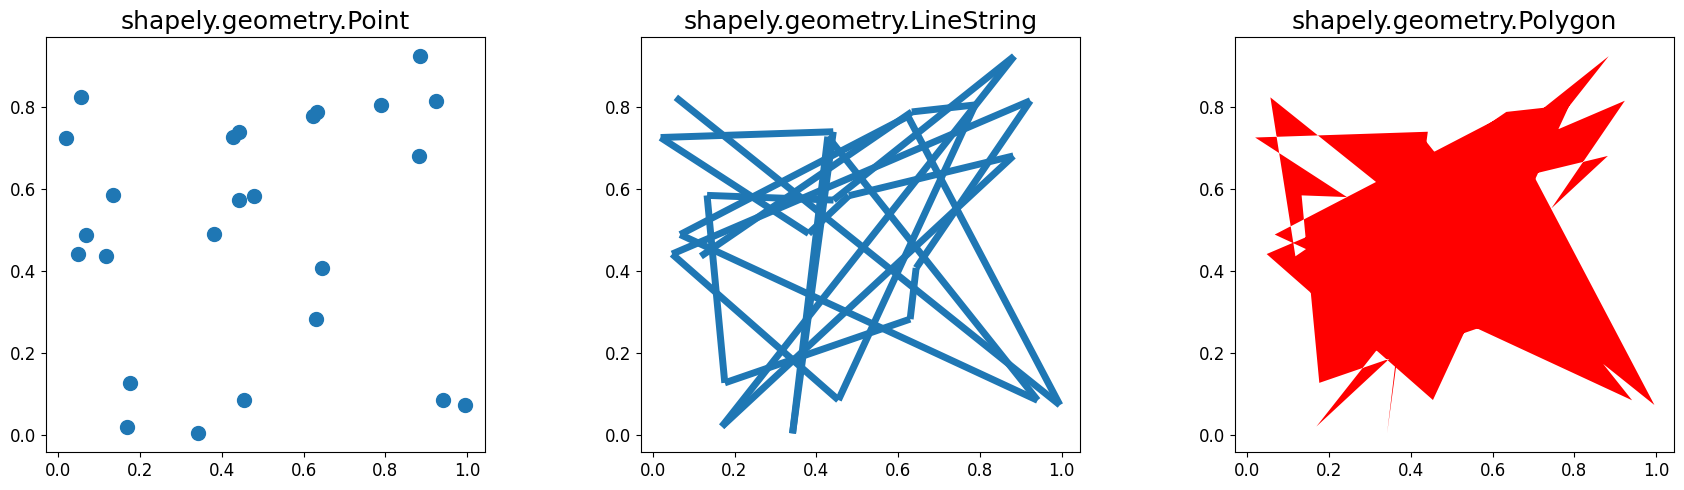

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
gpd.GeoSeries(points).plot(ax=ax[0], markersize=100)
gpd.GeoSeries(lines).plot(ax=ax[1], linewidth=5)
gpd.GeoSeries(polygon).plot(ax=ax[2], linewidth=5, color="red")
ax[0].set_title(f"shapely.geometry.Point", fontsize=18)
ax[1].set_title(f"shapely.geometry.LineString", fontsize=18)
ax[2].set_title(f"shapely.geometry.Polygon", fontsize=18)
ax[0].tick_params(axis="both", which="major", labelsize=12)
ax[0].tick_params(axis="both", which="minor", labelsize=12)
ax[1].tick_params(axis="both", which="major", labelsize=12)
ax[1].tick_params(axis="both", which="minor", labelsize=12)
ax[2].tick_params(axis="both", which="major", labelsize=12)
ax[2].tick_params(axis="both", which="minor", labelsize=12)
plt.tight_layout();

In [5]:
# the globe tower @ bgc taguig
COORD_TGT = (14.553514, 121.050110)
G_drive = make_graph(origin=COORD_TGT, network_type="drive")
G_walk = make_graph(origin=COORD_TGT, network_type="walk")
G_bike = make_graph(origin=COORD_TGT, network_type="bike")

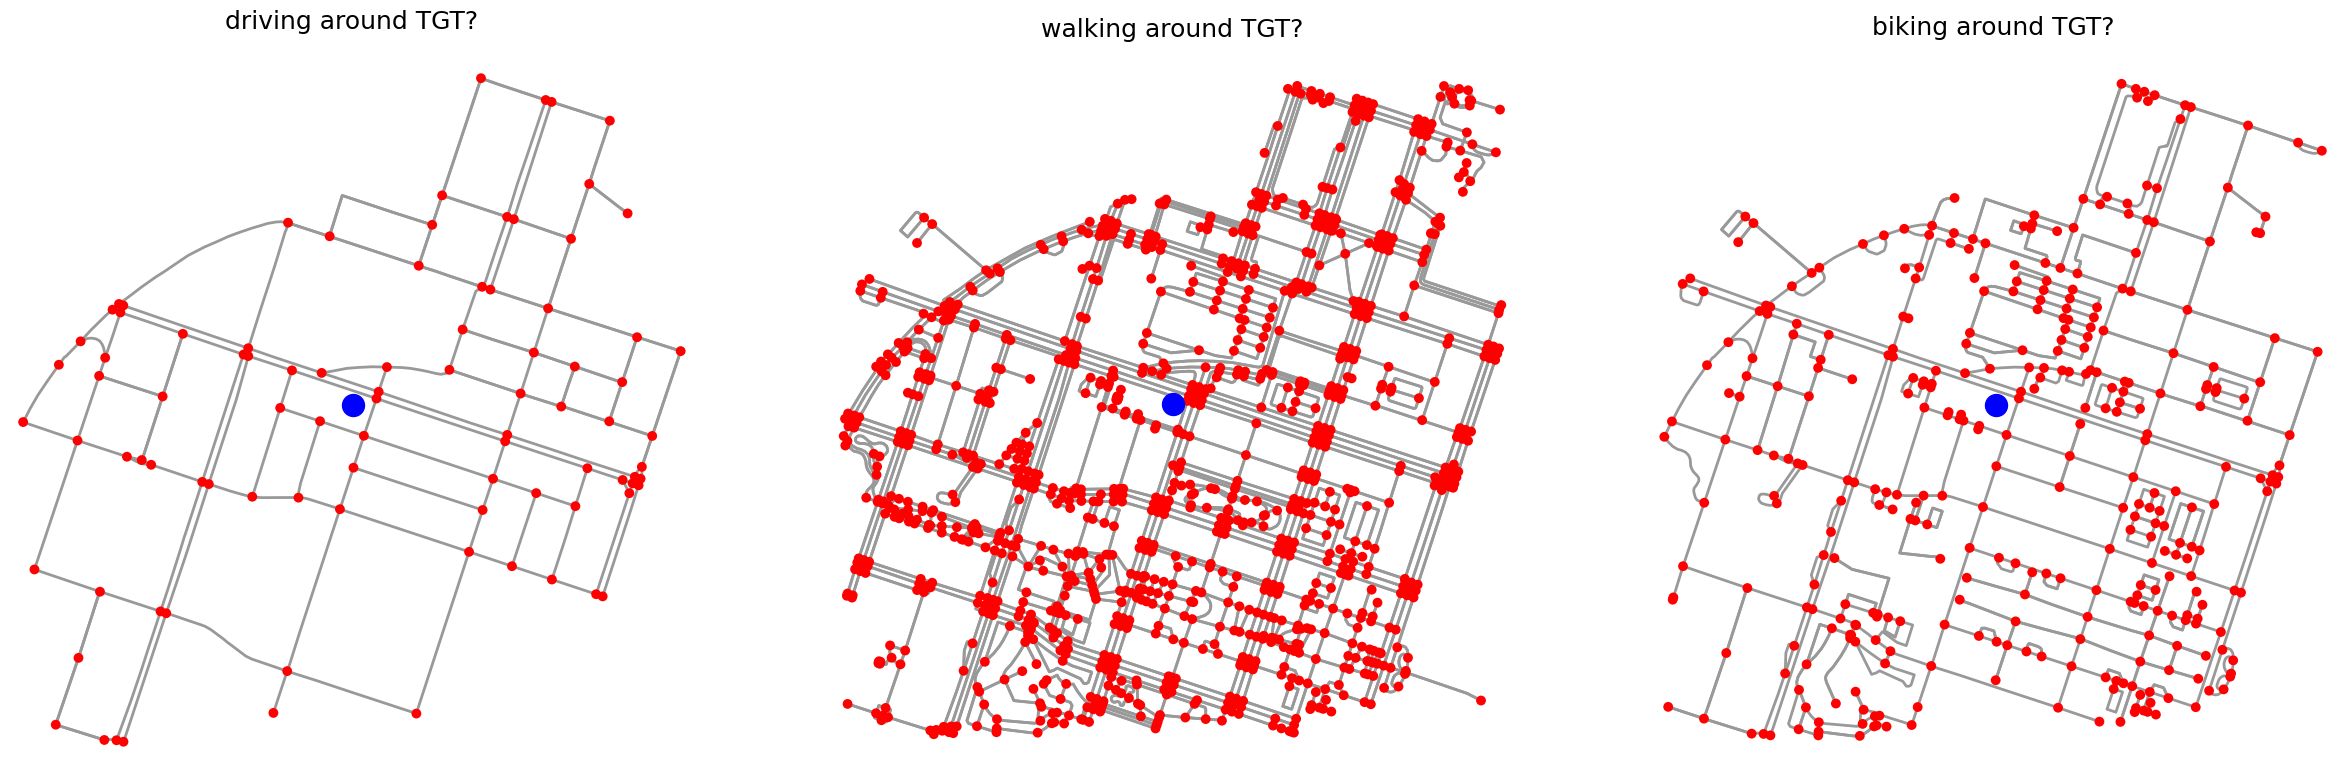

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ox.plot_graph(G=G_drive, ax=ax[0], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ox.plot_graph(G=G_walk, ax=ax[1], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ox.plot_graph(G=G_bike, ax=ax[2], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ax[0].set_title("driving around TGT?\n", fontsize=18)
ax[1].set_title("walking around TGT?\n", fontsize=18)
ax[2].set_title("biking around TGT?\n", fontsize=18)
ax[0].scatter(*COORD_TGT[::-1], c="blue", s=250)
ax[1].scatter(*COORD_TGT[::-1], c="blue", s=250)
ax[2].scatter(*COORD_TGT[::-1], c="blue", s=250);

In [7]:
COORD_WGC = (14.551534, 121.051751)
COORD_UPT = (14.556714, 121.054081)

In [8]:
orig = ox.distance.nearest_nodes(G_bike, *COORD_TGT[::-1])
dest = ox.distance.nearest_nodes(G_bike, *COORD_UPT[::-1])
route_od = ox.shortest_path(G_bike, orig, dest, weight="travel_time")
route_do = ox.shortest_path(G_bike, dest, orig, weight="travel_time")

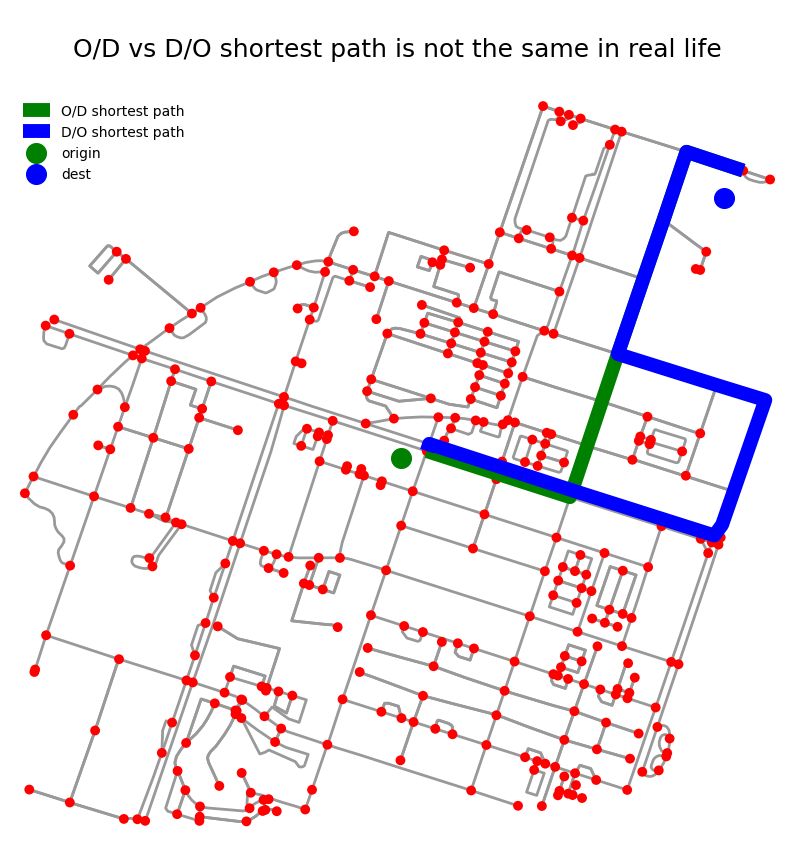

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ox.plot_graph(G=G_bike, ax=ax, node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
gpd.GeoSeries(shapely.geometry.LineString(get_coord_sequence(G_bike, route_od))).plot(ax=ax, color="green", linewidth=10)
gpd.GeoSeries(shapely.geometry.LineString(get_coord_sequence(G_bike, route_do))).plot(ax=ax, color="blue", linewidth=10)
ax.set_title("O/D vs D/O shortest path is not the same in real life\n", fontsize=18)
ax.scatter(*COORD_TGT[::-1], c="green", s=200)
ax.scatter(*COORD_UPT[::-1], c="blue", s=200)
ax.legend(["__", "__", "O/D shortest path", "D/O shortest path", "origin", "dest"], edgecolor="white", loc="upper left");

In [10]:
nodes_walk, edges_walk = ox.graph_to_gdfs(G_walk)
print(f"nodes_walk: {type(nodes_walk)}\n", f"edges_walk: {type(nodes_walk)}")

nodes_walk: <class 'geopandas.geodataframe.GeoDataFrame'>
 edges_walk: <class 'geopandas.geodataframe.GeoDataFrame'>


In [11]:
nodes_walk.head()

,y,x,highway,street_count,geometry
osmid,,,,,
32542716,14.549276,121.046034,traffic_signals,4,POINT (121.04603 14.54928)
32542900,14.550650,121.051385,crossing,4,POINT (121.05138 14.55065)
32542911,14.555931,121.049215,NaN,4,POINT (121.04922 14.55593)
32542971,14.553288,121.045587,traffic_signals,4,POINT (121.04559 14.55329)
32542973,14.554047,121.046076,NaN,3,POINT (121.04608 14.55405)


In [12]:
edges_walk.head()

osmid lanes         name       highway maxspeed   
u        v          key                                                        
32542716 6976286547 0      4940257     4   4th Avenue  unclassified       40  \
         6976286545 0     32488152     4  26th Street      tertiary       40   
         6976286544 0    814837410     4  26th Street      tertiary       40   
         6976286546 0    814837411     4   4th Avenue  unclassified       40   
32542900 271196480  0    690148299     3   9th Avenue      tertiary       40   

                         oneway reversed  length   
u        v          key                            
32542716 6976286547 0     False    False  12.259  \
         6976286545 0     False     True  11.169   
         6976286544 0     False    False   7.996   
         6976286546 0     False     True   7.419   
32542900 271196480  0     False     True  35.204   

                                                                    geometry   
u        v          key                                                        
32542716 6976286547 0    LINESTRING (121.04603 14.54928, 121.04607 14.54938)  \
         6976286545 0    LINESTRING (121.04603 14.54928, 121.04594 14.54931)   
         6976286544 0    LINESTRING (121.04603 14.54928, 121.04610 14.54925)   
         6976286546 0    LINESTRING (121.04603 14.54928, 121.04601 14.54921)   
32542900 271196480  0    LINESTRING (121.05138 14.55065, 121.05128 14.55035)   

                        access width service tunnel bridge  
u        v          key                                     
32542716 6976286547 0      NaN   NaN     NaN    NaN    NaN  
         6976286545 0      NaN   NaN     NaN    NaN    NaN  
         6976286544 0      NaN   NaN     NaN    NaN    NaN  
         6976286546 0      NaN   NaN     NaN    NaN    NaN  
32542900 271196480  0      NaN   NaN     NaN    NaN    NaN

In [16]:
lat_min, lng_min = 14.548911, 121.046453
lat_max, lng_max = 14.552861, 121.054499
bounds = lng_min, lng_max, lat_min, lat_max

In [19]:
?make_points

Signature: make_points(num_points, lng_min, lng_max, lat_min, lat_max)
Docstring: <no docstring>
File:      /var/folders/3y/777cyz4n735bsqlbp0xg5vtc0000gp/T/ipykernel_64617/2875109414.py
Type:      function


In [24]:
points = make_points(100, *bounds)

In [36]:
points

[(121.04659681661444, 14.54945007992177),
 (121.05278052665497, 14.552603241836387),
 (121.05022405110647, 14.551625726780026),
 (121.04990635666263, 14.550101718818897),
 (121.04735787690522, 14.550267548669654),
 (121.05063098563998, 14.54977867393601),
 (121.05084747921457, 14.551123118331905),
 (121.04860990983582, 14.55273320257859),
 (121.0498695952506, 14.551256199369318),
 (121.05446571139974, 14.548963332664746),
 (121.05129957549846, 14.552234215860533),
 (121.04673951565671, 14.551103759299519),
 (121.05339118820852, 14.551570442715121),
 (121.05378950711521, 14.55161297781117),
 (121.05063429933922, 14.550083224369002),
 (121.05024620117811, 14.550595661611787),
 (121.04950515714158, 14.551271865156338),
 (121.05349084793261, 14.552598658516859),
 (121.0508502971754, 14.550138621276767),
 (121.05448337374499, 14.551605057779462),
 (121.0515995899221, 14.551923606383108),
 (121.04863797979787, 14.550370556804811),
 (121.0513731154856, 14.550826523955337),
 (121.0524691495639

## 4. Dev notes and programming hacks

## 5. References

1. https://carto.com/what-is-spatial-data-science